In [1]:
import torch 
import torch.nn as nn
import os 
import sys
# Get the absolute path of the project root
project_root = os.path.abspath("..")  # Adjust if needed

# Add the project root to sys.path
if project_root not in sys.path:
    sys.path.append(project_root)

from proteinshake.datasets import ProteinLigandInterfaceDataset, AlphaFoldDataset, GeneOntologyDataset, ProteinFamilyDataset
from src.utils import data_utils as dtu
from torch.utils.data import DataLoader, Dataset, Subset
from src.models.basicVae import LitBasicVae
# from src.models.basicVae_pyt import BasicVae
import numpy as np
import matplotlib.pyplot as plt
from src.dataset_classes.sequenceDataset import *
from sklearn.model_selection import KFold
%load_ext autoreload
%autoreload 2

In [2]:
dataset = ProteinFamilyDataset(root='../data').to_point().torch()

In [7]:
dataset[0][1]['residue'].keys()

dict_keys(['residue_number', 'residue_type', 'x', 'y', 'z', 'SASA', 'RSA'])

In [3]:
import random

indices = list(range(100))  # Example list of indices
subset_size = 10  # Size of the random subset

random_subset = random.sample(indices, subset_size)  # Get random subset
remaining_subset = list(set(indices) - set(random_subset))  # Get remaining indices

print("Random Subset:", random_subset)
print("Remaining Subset:", remaining_subset)

Random Subset: [79, 41, 49, 85, 60, 97, 64, 52, 92, 20]
Remaining Subset: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 42, 43, 44, 45, 46, 47, 48, 50, 51, 53, 54, 55, 56, 57, 58, 59, 61, 62, 63, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 80, 81, 82, 83, 84, 86, 87, 88, 89, 90, 91, 93, 94, 95, 96, 98, 99]


In [4]:
idx_list = range(len(dataset))
subset_size = int(len(dataset)//10)
val_idx = random.sample(idx_list, subset_size)  # Get random subset
train_idx = list(set(idx_list) - set(val_idx))

In [5]:
s = 500
train_subset = SequenceDataset(Subset(dataset, train_idx), s)
val_subset = SequenceDataset(Subset(dataset, val_idx), s)

100%|██████████| 3110/3110 [00:00<00:00, 3606.45it/s]


In [6]:
latent_dim = 32
epochs = 100
lr = 0.001
batch_size = 256
train_dataloader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_subset,batch_size=batch_size, shuffle=False)
x_dim = train_subset[0].shape[0]
if torch.cuda.is_available():
    torch.cuda.current_device()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [112]:
model = LitBasicVae(latent_dim = latent_dim, 
                    seq_len = s, hidden_dim = 1024, 
                    amino_acids = 21, optimizer=torch.optim.Adam, 
                    optimizer_param={'lr':0.001}, dropout = 0.0, reconstruction_loss_weight = 1, beta = 0.01, 
                    beta_increment = 0, 
                    beta_epoch_start = 20,
                    beta_cycle = 30)
model

LitBasicVae(
  (tanh): Tanh()
  (soft): Softmax(dim=2)
  (dropout_layer): Dropout(p=0.0, inplace=False)
  (fc1_enc): Linear(in_features=10500, out_features=1024, bias=True)
  (fc3_enc_mean): Linear(in_features=1024, out_features=32, bias=True)
  (fc3_enc_logvar): Linear(in_features=1024, out_features=32, bias=True)
  (fc1_dec): Linear(in_features=32, out_features=1024, bias=True)
  (fc3_dec): Linear(in_features=1024, out_features=10500, bias=True)
)

In [113]:
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import EarlyStopping
import pytorch_lightning as pl
optimizer = torch.optim.Adam
optimizer_param = {'lr':0.001}
trainer = pl.Trainer(max_epochs=epochs,
    accelerator="auto",
    devices="auto",
    logger=TensorBoardLogger(save_dir="logs/"))
# model = LitBasicVae(latent_dim, x_dim, optimizer, optimizer_param,)


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [114]:
trainer.fit(model, train_dataloader, val_dataloader)


  | Name           | Type    | Params | Mode 
---------------------------------------------------
0 | tanh           | Tanh    | 0      | train
1 | soft           | Softmax | 0      | train
2 | dropout_layer  | Dropout | 0      | train
3 | fc1_enc        | Linear  | 10.8 M | train
4 | fc3_enc_mean   | Linear  | 32.8 K | train
5 | fc3_enc_logvar | Linear  | 32.8 K | train
6 | fc1_dec        | Linear  | 33.8 K | train
7 | fc3_dec        | Linear  | 10.8 M | train
---------------------------------------------------
21.6 M    Trainable params
0         Non-trainable params
21.6 M    Total params
86.460    Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]


Detected KeyboardInterrupt, attempting graceful shutdown ...


NameError: name 'exit' is not defined

# Model Visualisation

In [55]:
dataset = ProteinFamilyDataset(root = '../data').to_point().torch()

In [32]:
# Load the trained model from checkpoint
checkpoint_path = "../trained_models/Pfam/optimise_bvae/12-25-03_SWEEP2_Pfam_BasicVAE_study_BS128_MS500_trials30/11_LD16_HD512_Beta0.005_BetaInc0.ckpt"
model = LitBasicVae.load_from_checkpoint(checkpoint_path)

# Put model in evaluation mode
model.eval()


/opt/anaconda3/envs/ProteinManifoldLearning/lib/python3.10/site-packages/pytorch_lightning/core/module.py:441: You are trying to `self.log()` but the `self.trainer` reference is not registered on the model yet. This is most likely because the model hasn't been passed to the `Trainer`


LitBasicVae(
  (tanh): Tanh()
  (soft): Softmax(dim=2)
  (dropout_layer): Dropout(p=0, inplace=False)
  (fc1_enc): Linear(in_features=10500, out_features=512, bias=True)
  (fc3_enc_mean): Linear(in_features=512, out_features=16, bias=True)
  (fc3_enc_logvar): Linear(in_features=512, out_features=16, bias=True)
  (fc1_dec): Linear(in_features=16, out_features=512, bias=True)
  (fc3_dec): Linear(in_features=512, out_features=10500, bias=True)
)

In [33]:
input = next(iter(train_dataloader))
model.to('cpu')

LitBasicVae(
  (tanh): Tanh()
  (soft): Softmax(dim=2)
  (dropout_layer): Dropout(p=0, inplace=False)
  (fc1_enc): Linear(in_features=10500, out_features=512, bias=True)
  (fc3_enc_mean): Linear(in_features=512, out_features=16, bias=True)
  (fc3_enc_logvar): Linear(in_features=512, out_features=16, bias=True)
  (fc1_dec): Linear(in_features=16, out_features=512, bias=True)
  (fc3_dec): Linear(in_features=512, out_features=10500, bias=True)
)

In [34]:
reparam_z, x_mu, x_logvar, x_rec, logit = model(input)

In [35]:
seq_dataset = SequenceDataset(dataset, 500, return_proteins=True)
seq_dataloader = DataLoader(seq_dataset, batch_size= 256, shuffle = False)

100%|██████████| 31109/31109 [00:08<00:00, 3773.10it/s]


In [36]:
# lengths = [k[0].shape[0] for k in seq_dataset.org_protein_data]
families = [k[1]['protein']['Pfam'][0] for k in seq_dataset.org_protein_data]

In [37]:
if torch.cuda.is_available():
    torch.cuda.current_device()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

LitBasicVae(
  (tanh): Tanh()
  (soft): Softmax(dim=2)
  (dropout_layer): Dropout(p=0, inplace=False)
  (fc1_enc): Linear(in_features=10500, out_features=512, bias=True)
  (fc3_enc_mean): Linear(in_features=512, out_features=16, bias=True)
  (fc3_enc_logvar): Linear(in_features=512, out_features=16, bias=True)
  (fc1_dec): Linear(in_features=16, out_features=512, bias=True)
  (fc3_dec): Linear(in_features=512, out_features=10500, bias=True)
)

In [38]:
labels = []
latent_coord = []
model.eval()
total_samples = []
lengths = []
i_amino_count = {i:[] for i in range(21)}
for batch_i, batch in enumerate(seq_dataloader):
    lengths.append(torch.sum((torch.sum(batch, dim = -1) != 0), dim = -1))
    for i in range(21):
        i_amino_count[i].extend(torch.sum(batch.argmax(-1) == i, axis = -1))
    # labels.append(batch[1].to('cpu').numpy())
    rep_z, x_mu, x_logvar, x_rec, logit = model(batch)
    total_samples.append(x_mu.shape[0])
    latent_coord.append(x_mu.detach().numpy())
# labels = np.concatenate(labels)``
latent_coord = np.concatenate(latent_coord, axis = 0)

In [39]:
import umap
U, S, V = torch.pca_lowrank(torch.tensor(latent_coord), q=None, center=True, niter=2)

# Apply UMAP
reducer = umap.UMAP(n_components=2)
reduced_data = reducer.fit_transform(latent_coord)

/opt/anaconda3/envs/ProteinManifoldLearning/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [220]:
projected_data = reduced_data

In [40]:
projected_data = torch.matmul(torch.tensor(latent_coord), V[:, :2]) 
# torch.vstack(i_amino_count[2]).squeeze().cpu().numpy()
# projected_data = latent_coord

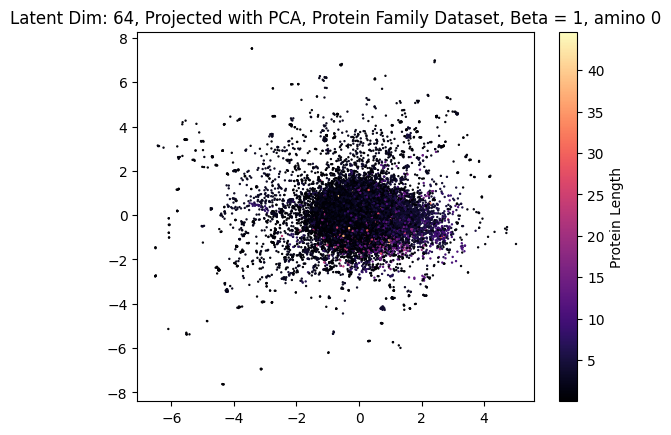

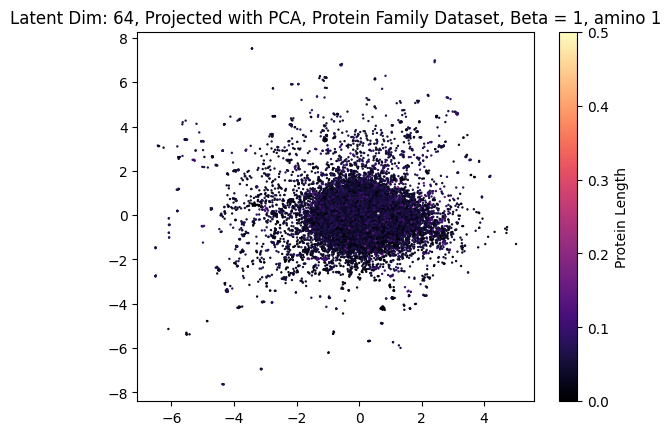

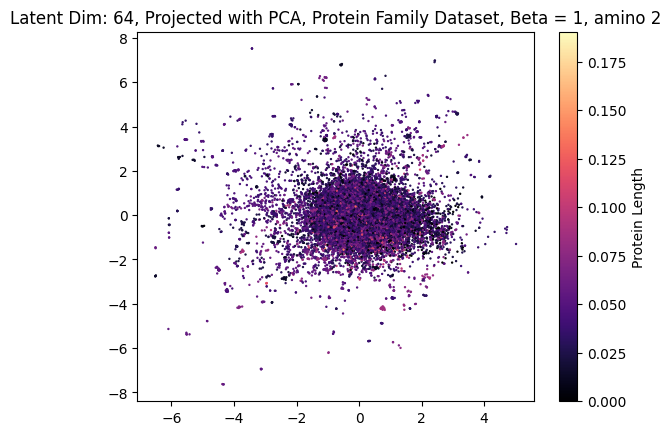

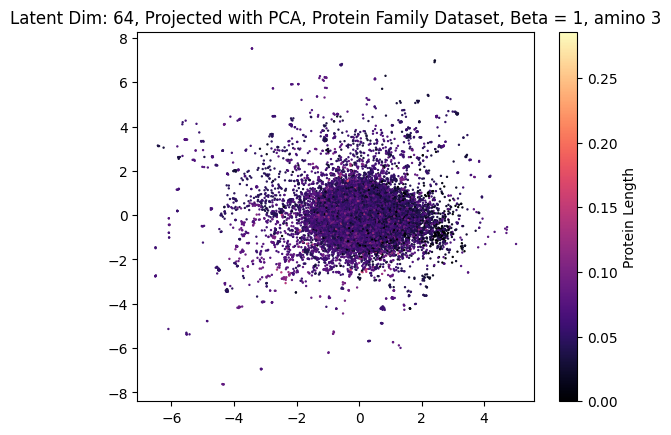

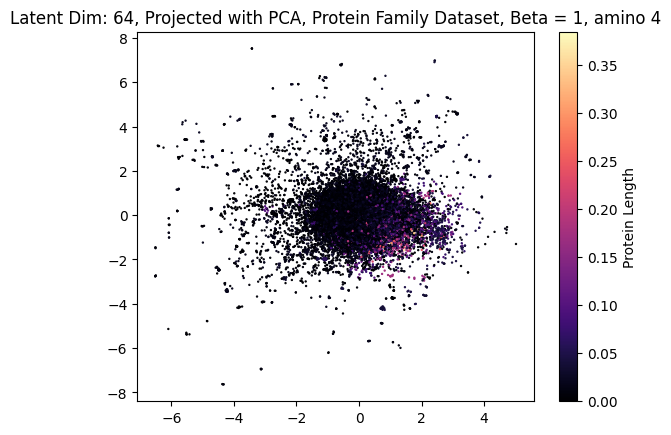

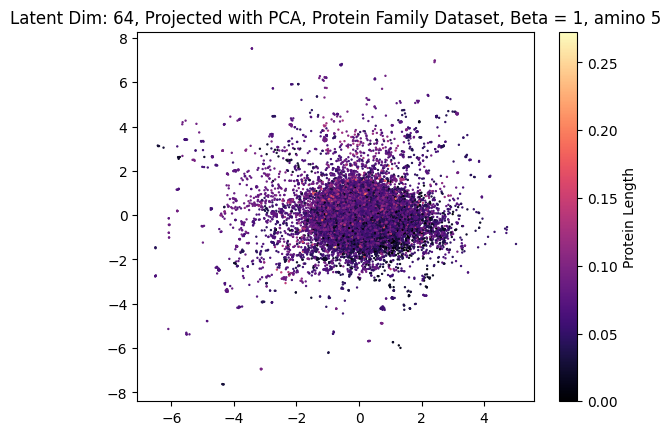

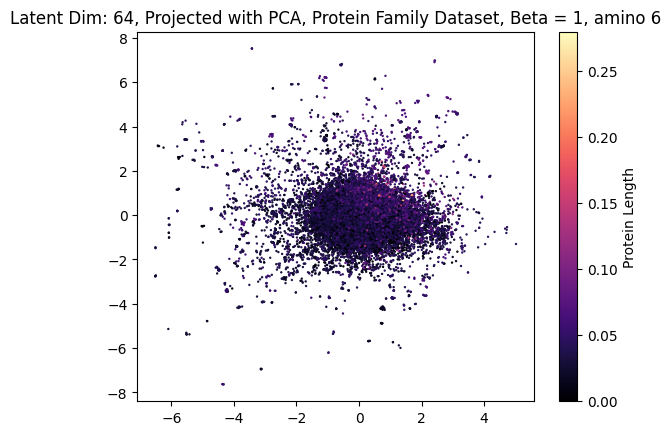

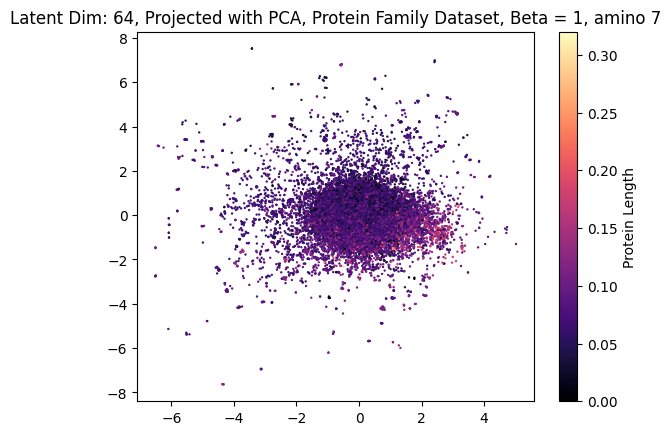

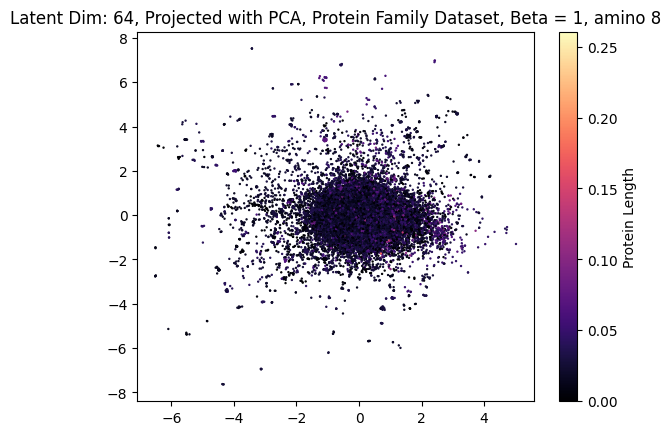

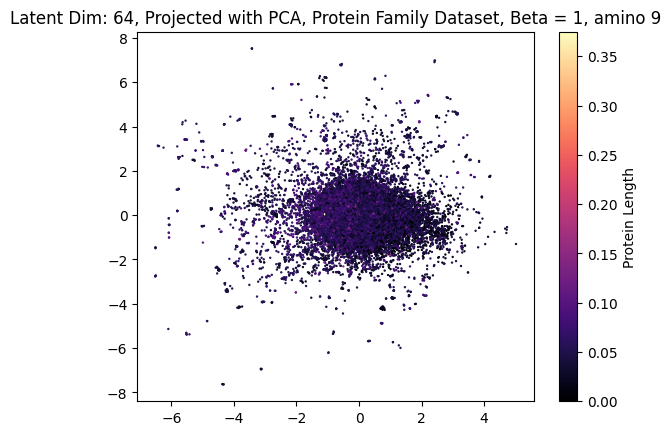

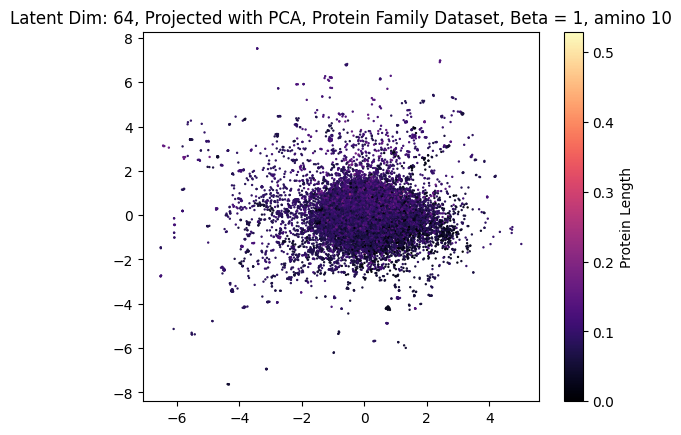

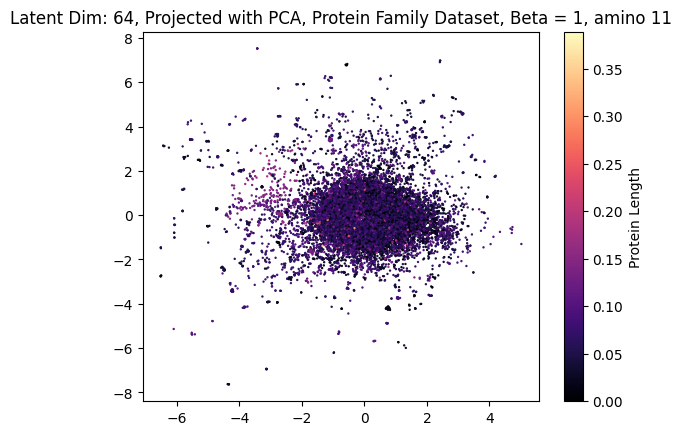

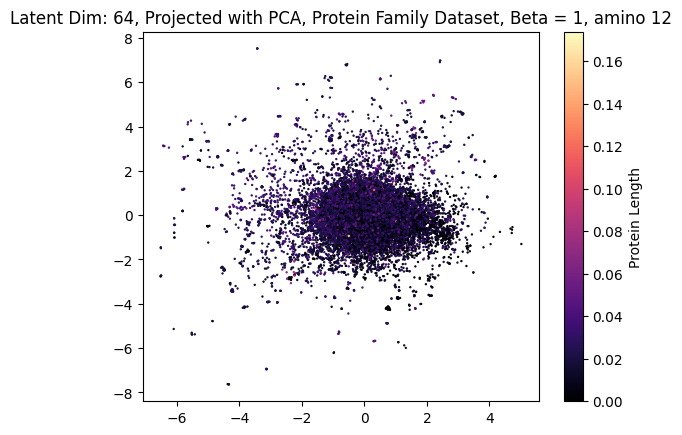

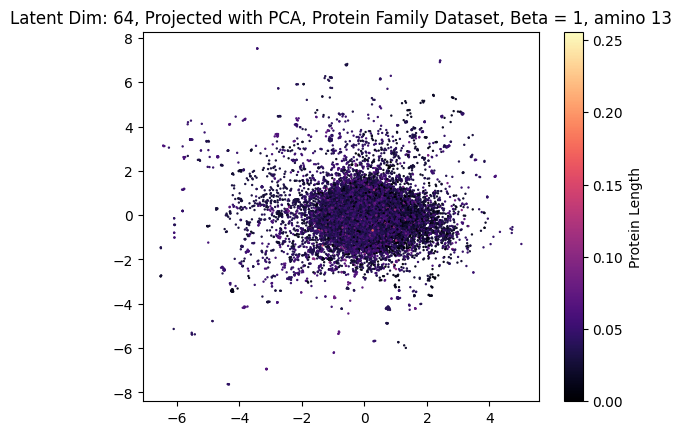

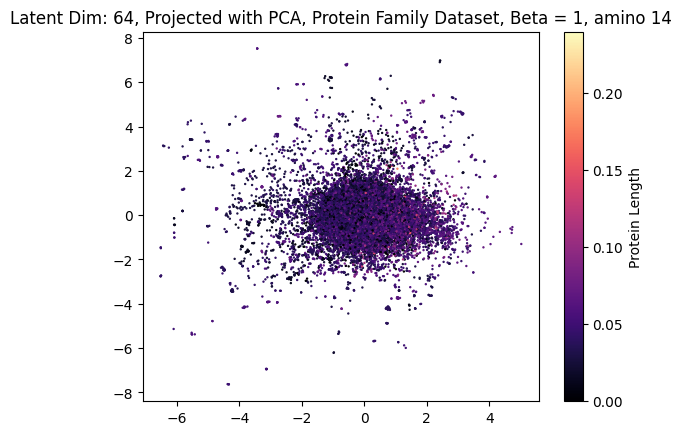

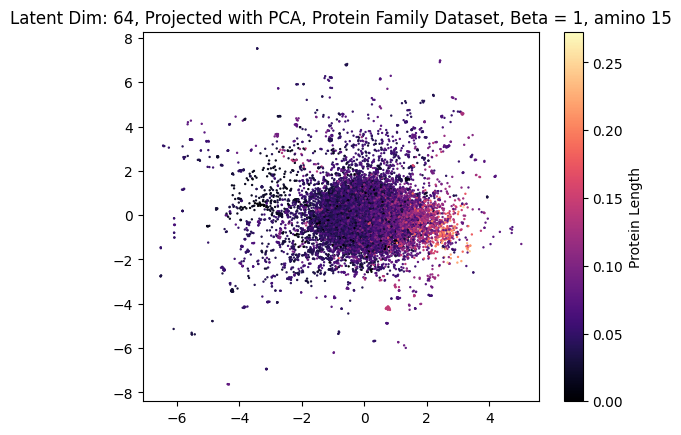

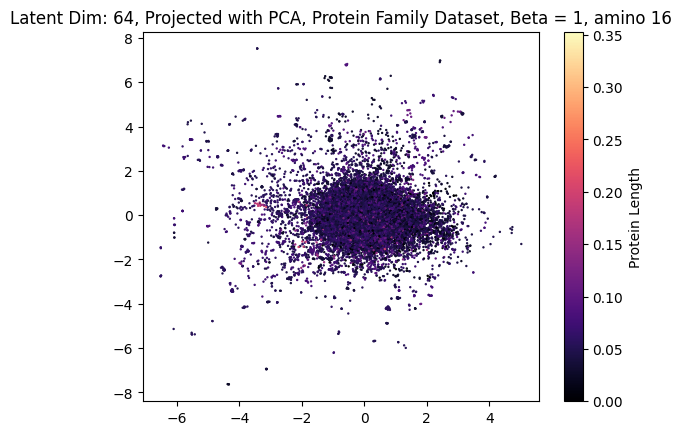

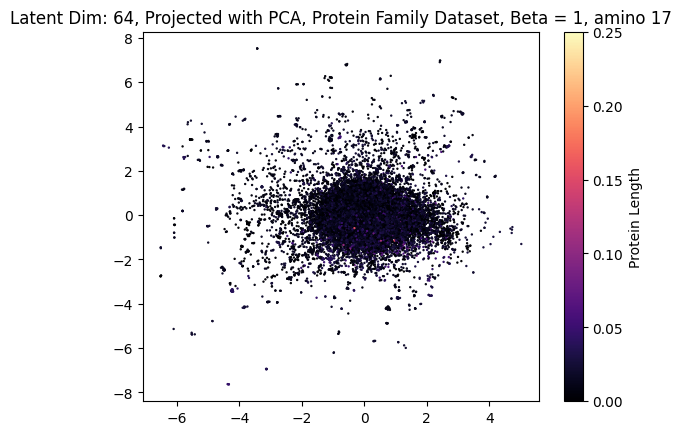

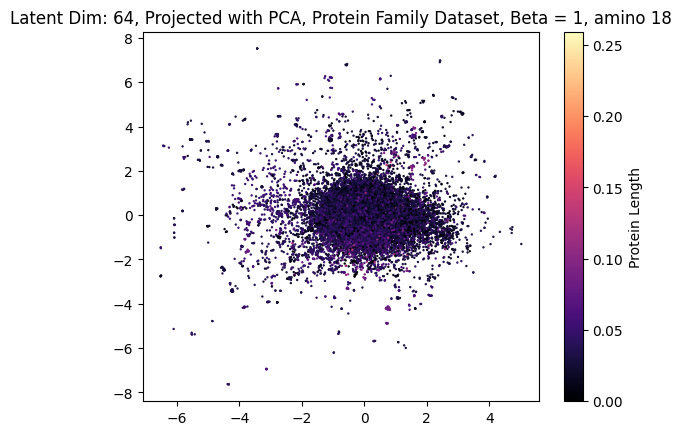

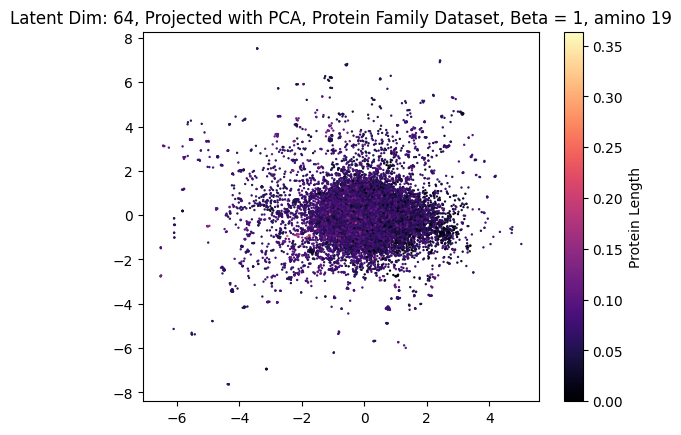

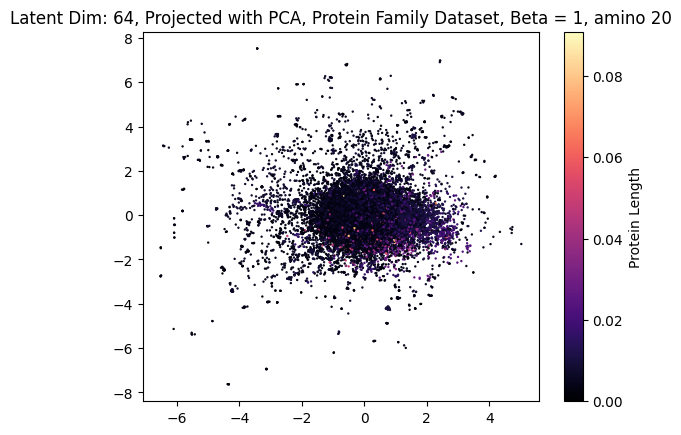

In [41]:
import matplotlib.pyplot as plt
for i in range(21):

    perc_i_amino = (torch.vstack(i_amino_count[i]).squeeze() / torch.concatenate(lengths))
    plt.scatter(projected_data[:, 0], projected_data[:, 1], s = 0.5, c=perc_i_amino.cpu().numpy(), cmap='magma')
    plt.colorbar(label = 'Protein Length')
    plt.title(f'Latent Dim: 64, Projected with PCA, Protein Family Dataset, Beta = 1, amino {i}')
    plt.show()
    # plt.savefig("exp_1_latent_Pfam.png")

The most common protein family is: PF00041


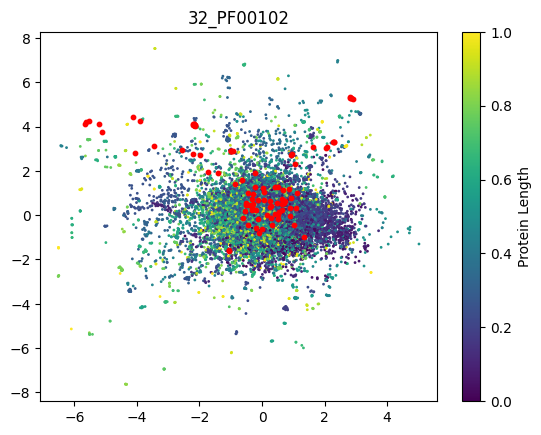

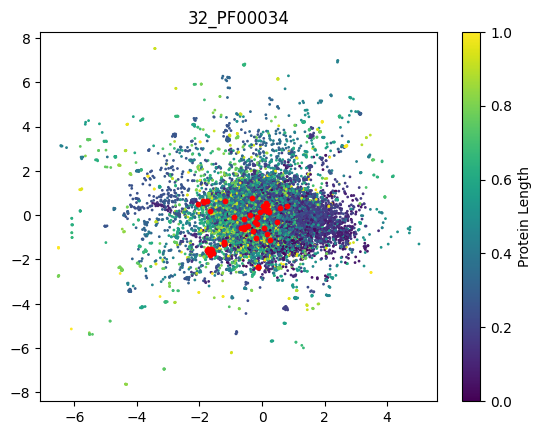

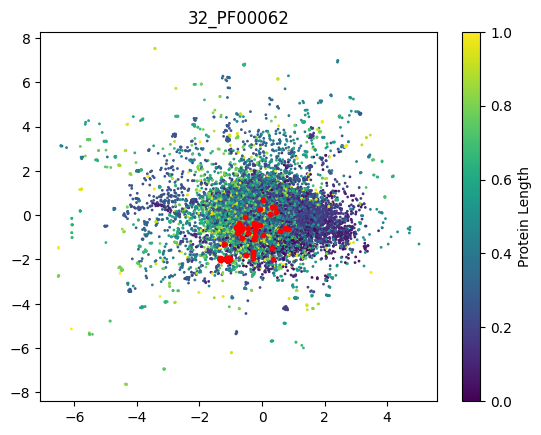

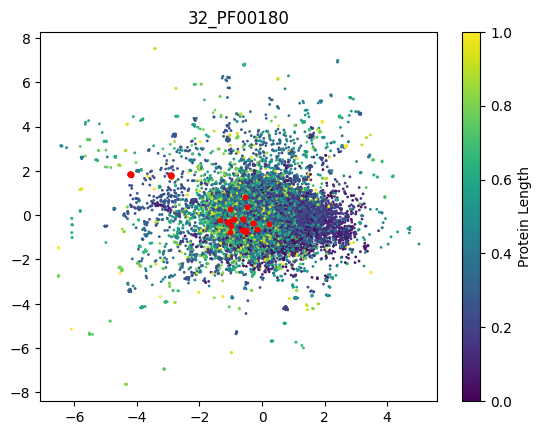

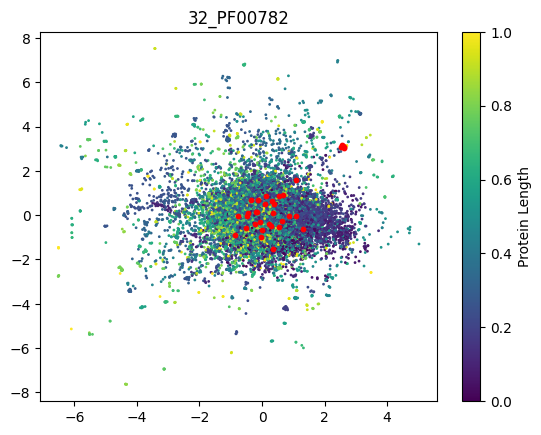

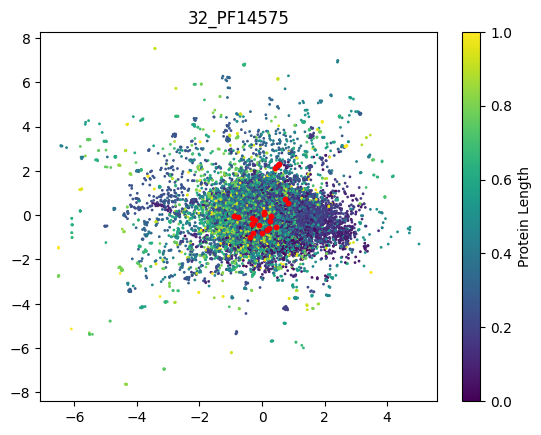

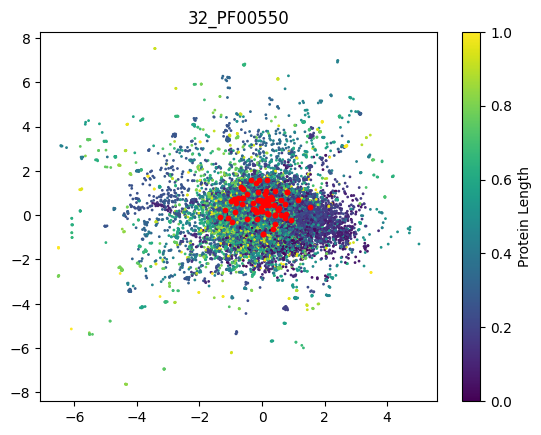

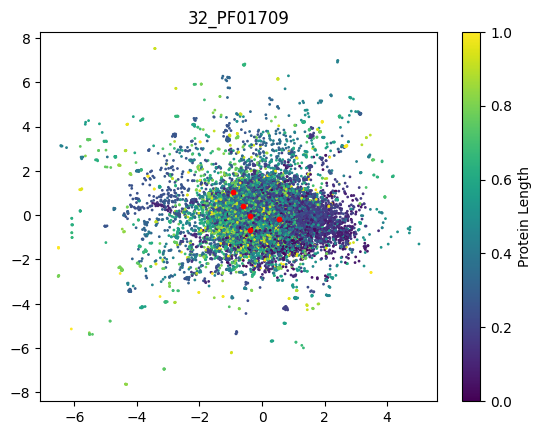

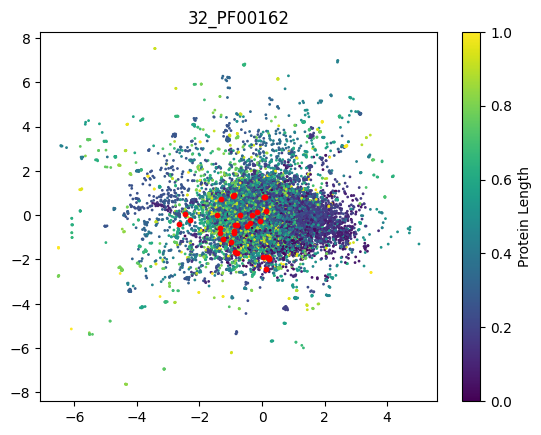

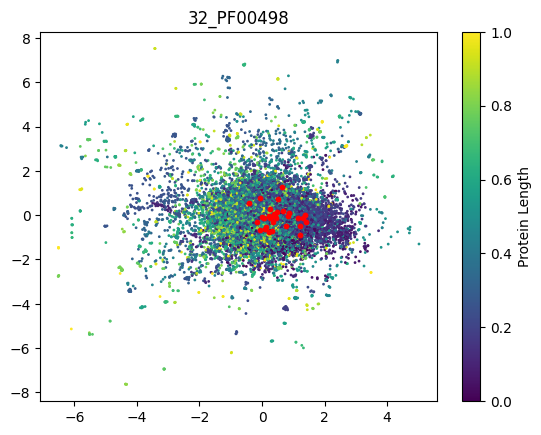

In [42]:
from collections import Counter
# Example list of strings
protein_families = families
# Count occurrences of each element
counter = Counter(protein_families)

# Get the most common element (returns a list of tuples (element, count))
most_common = counter.most_common(1)

# Extract the most common string
if most_common:
    most_common_string = 'PF00041'#most_common[0][0]  # The string of the most common element
else:
    most_common_string = None

print(f"The most common protein family is: {most_common_string}")
for i in protein_families[:10]:
    most_common_string = i
    family_array = np.array(families)
    most_common_indices = np.where((family_array == most_common_string) == 1)
    most_common_points = projected_data[most_common_indices, :]
    try:
        plt.scatter(projected_data[:, 0], projected_data[:, 1], s = 1, c=torch.concatenate(lengths), cmap='viridis')
        plt.scatter(most_common_points.squeeze()[:, 0], most_common_points.squeeze()[:, 1], s = 10, c='r')

        plt.colorbar(label = 'Protein Length')
        plt.title(f'{latent_dim}_{i}')
        plt.show()
    except:
        continue

In [43]:
from sklearn.manifold import TSNE
import numpy as np

# Example: Random high-dimensional data (e.g., 100 samples with 50 features)
data = latent_coord

# Apply t-SNE
tsne = TSNE(n_components=2, perplexity=10, n_iter=300)
tsne_results = tsne.fit_transform(data)

/opt/anaconda3/envs/ProteinManifoldLearning/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


The most common protein family is: PF00085


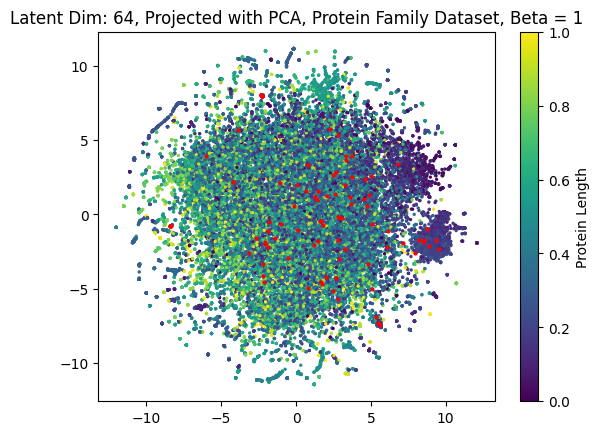

In [44]:
from sklearn.manifold import TSNE
import numpy as np

protein_families = families
# Count occurrences of each element
counter = Counter(protein_families)

# Get the most common element (returns a list of tuples (element, count))
most_common = counter.most_common(1)

# Extract the most common string
if most_common:
    most_common_string = 'PF00085'# most_common[0][0]  # The string of the most common element
else:
    most_common_string = None

print(f"The most common protein family is: {most_common_string}")

family_array = np.array(families)
most_common_indices = np.where((family_array == most_common_string) == 1)
most_common_points = tsne_results[most_common_indices, :]

plt.scatter(tsne_results[:, 0], tsne_results[:, 1], s = 2, c=torch.concatenate(lengths), cmap='viridis')
plt.scatter(most_common_points.squeeze()[:, 0], most_common_points.squeeze()[:, 1], s = 4, c='r')

plt.colorbar(label = 'Protein Length')
plt.title('Latent Dim: 64, Projected with PCA, Protein Family Dataset, Beta = 1')
plt.savefig("exp_1_latent_Pfam.png")

### Sample Sequence Visualisation

In [11]:
# Load the trained model from checkpoint
checkpoint_path = "../trained_models/Pfam/optimise_bvae/12-25-03_SWEEP2_Pfam_BasicVAE_study_BS128_MS500_trials30/5_LD16_HD512_Beta0.005_BetaInc0.ckpt"
model = LitBasicVae.load_from_checkpoint(checkpoint_path)

# Put model in evaluation mode
model.eval()

model.to('cpu')

/opt/anaconda3/envs/ProteinManifoldLearning/lib/python3.10/site-packages/pytorch_lightning/core/module.py:441: You are trying to `self.log()` but the `self.trainer` reference is not registered on the model yet. This is most likely because the model hasn't been passed to the `Trainer`


LitBasicVae(
  (tanh): Tanh()
  (soft): Softmax(dim=2)
  (dropout_layer): Dropout(p=0, inplace=False)
  (fc1_enc): Linear(in_features=10500, out_features=512, bias=True)
  (fc3_enc_mean): Linear(in_features=512, out_features=16, bias=True)
  (fc3_enc_logvar): Linear(in_features=512, out_features=16, bias=True)
  (fc1_dec): Linear(in_features=16, out_features=512, bias=True)
  (fc3_dec): Linear(in_features=512, out_features=10500, bias=True)
)

In [15]:
seq_dataset = SequenceDataset(dataset, 500, return_proteins=True)
seq_dataloader = DataLoader(seq_dataset, batch_size= 256, shuffle = False)

100%|██████████| 31109/31109 [00:06<00:00, 4614.81it/s]


In [185]:
idx = 0
batch_sample = next(iter(seq_dataloader))
batch_out = model(batch_sample)

In [202]:
for idx, sample in enumerate(seq_dataset):
    z = model(sample)
    output = model.decode(z[1])
    output = output[0].squeeze().argmax(dim = -1)[:]
    x_true_indices = sample.argmax(dim=-1)
    x_true_indices[torch.where(torch.sum(sample, dim = -1) == 0)] = -1
    end_idx = torch.where(x_true_indices != -1)[-1][-1].item()
    original = sample.argmax(dim=-1)[:]
    try:
        if torch.where(output == 20)[0][0].item() != end_idx:
            print(f'END {end_idx} Proposed {torch.where(output == 20)[0][0].item()}')
            print(idx)
    except:
        continue
    
    


END 277 Proposed 448
0
END 121 Proposed 425
1
END 359 Proposed 444
3
END 170 Proposed 484
4
END 293 Proposed 372
5
END 76 Proposed 489
6
END 233 Proposed 486
7
END 125 Proposed 490
9
END 91 Proposed 453
11
END 389 Proposed 429
13
END 18 Proposed 332
14
END 270 Proposed 452
15
END 160 Proposed 429
17
END 236 Proposed 454
18
END 404 Proposed 408
19
END 162 Proposed 497
20
END 87 Proposed 84
21
END 37 Proposed 467
23
END 92 Proposed 459
24
END 113 Proposed 112
26
END 102 Proposed 450
27
END 333 Proposed 450
28
END 439 Proposed 397
29
END 316 Proposed 460
30
END 151 Proposed 480
31
END 97 Proposed 316
32
END 204 Proposed 453
35
END 265 Proposed 264
36
END 193 Proposed 472
37
END 149 Proposed 443
39
END 224 Proposed 225
40
END 172 Proposed 489
41
END 161 Proposed 416
43
END 260 Proposed 494
44
END 368 Proposed 99
46
END 316 Proposed 272
48
END 195 Proposed 197
49
END 61 Proposed 41
50
END 225 Proposed 471
51
END 45 Proposed 469
52
END 146 Proposed 122
53
END 404 Proposed 450
54
END 325 Prop

In [283]:
in_sample = seq_dataset[28461]
z = model(in_sample)

start_mean = z[1] #atch_out[1][idx]
start_std = z[2] #batch_out[2][idx]

point_interpolates = []

for i in range(0,3):
    point_interpolates.append(start_mean + start_std*(i))

In [284]:
model_interpolate_reconstructions = []

for sample in point_interpolates:
    output = model.decode(sample)
    model_interpolate_reconstructions.append(output)

In [285]:
x_true_indices = in_sample.argmax(dim=-1) #batch_sample[idx].argmax(dim=-1)
x_true_indices[torch.where(torch.sum(in_sample, dim = -1) == 0)] = -1
end_idx = torch.where(x_true_indices != -1)[-1][-1].item()
original = in_sample.argmax(dim=-1)[:]
sequence_vectors = [original]

for model_int in model_interpolate_reconstructions:
    sequence_vectors.append(model_int[0].squeeze().argmax(dim = -1)[:])

In [286]:
difference_vectors = np.array([(seq_vec == x_true_indices).to(torch.int).numpy() for seq_vec in sequence_vectors])

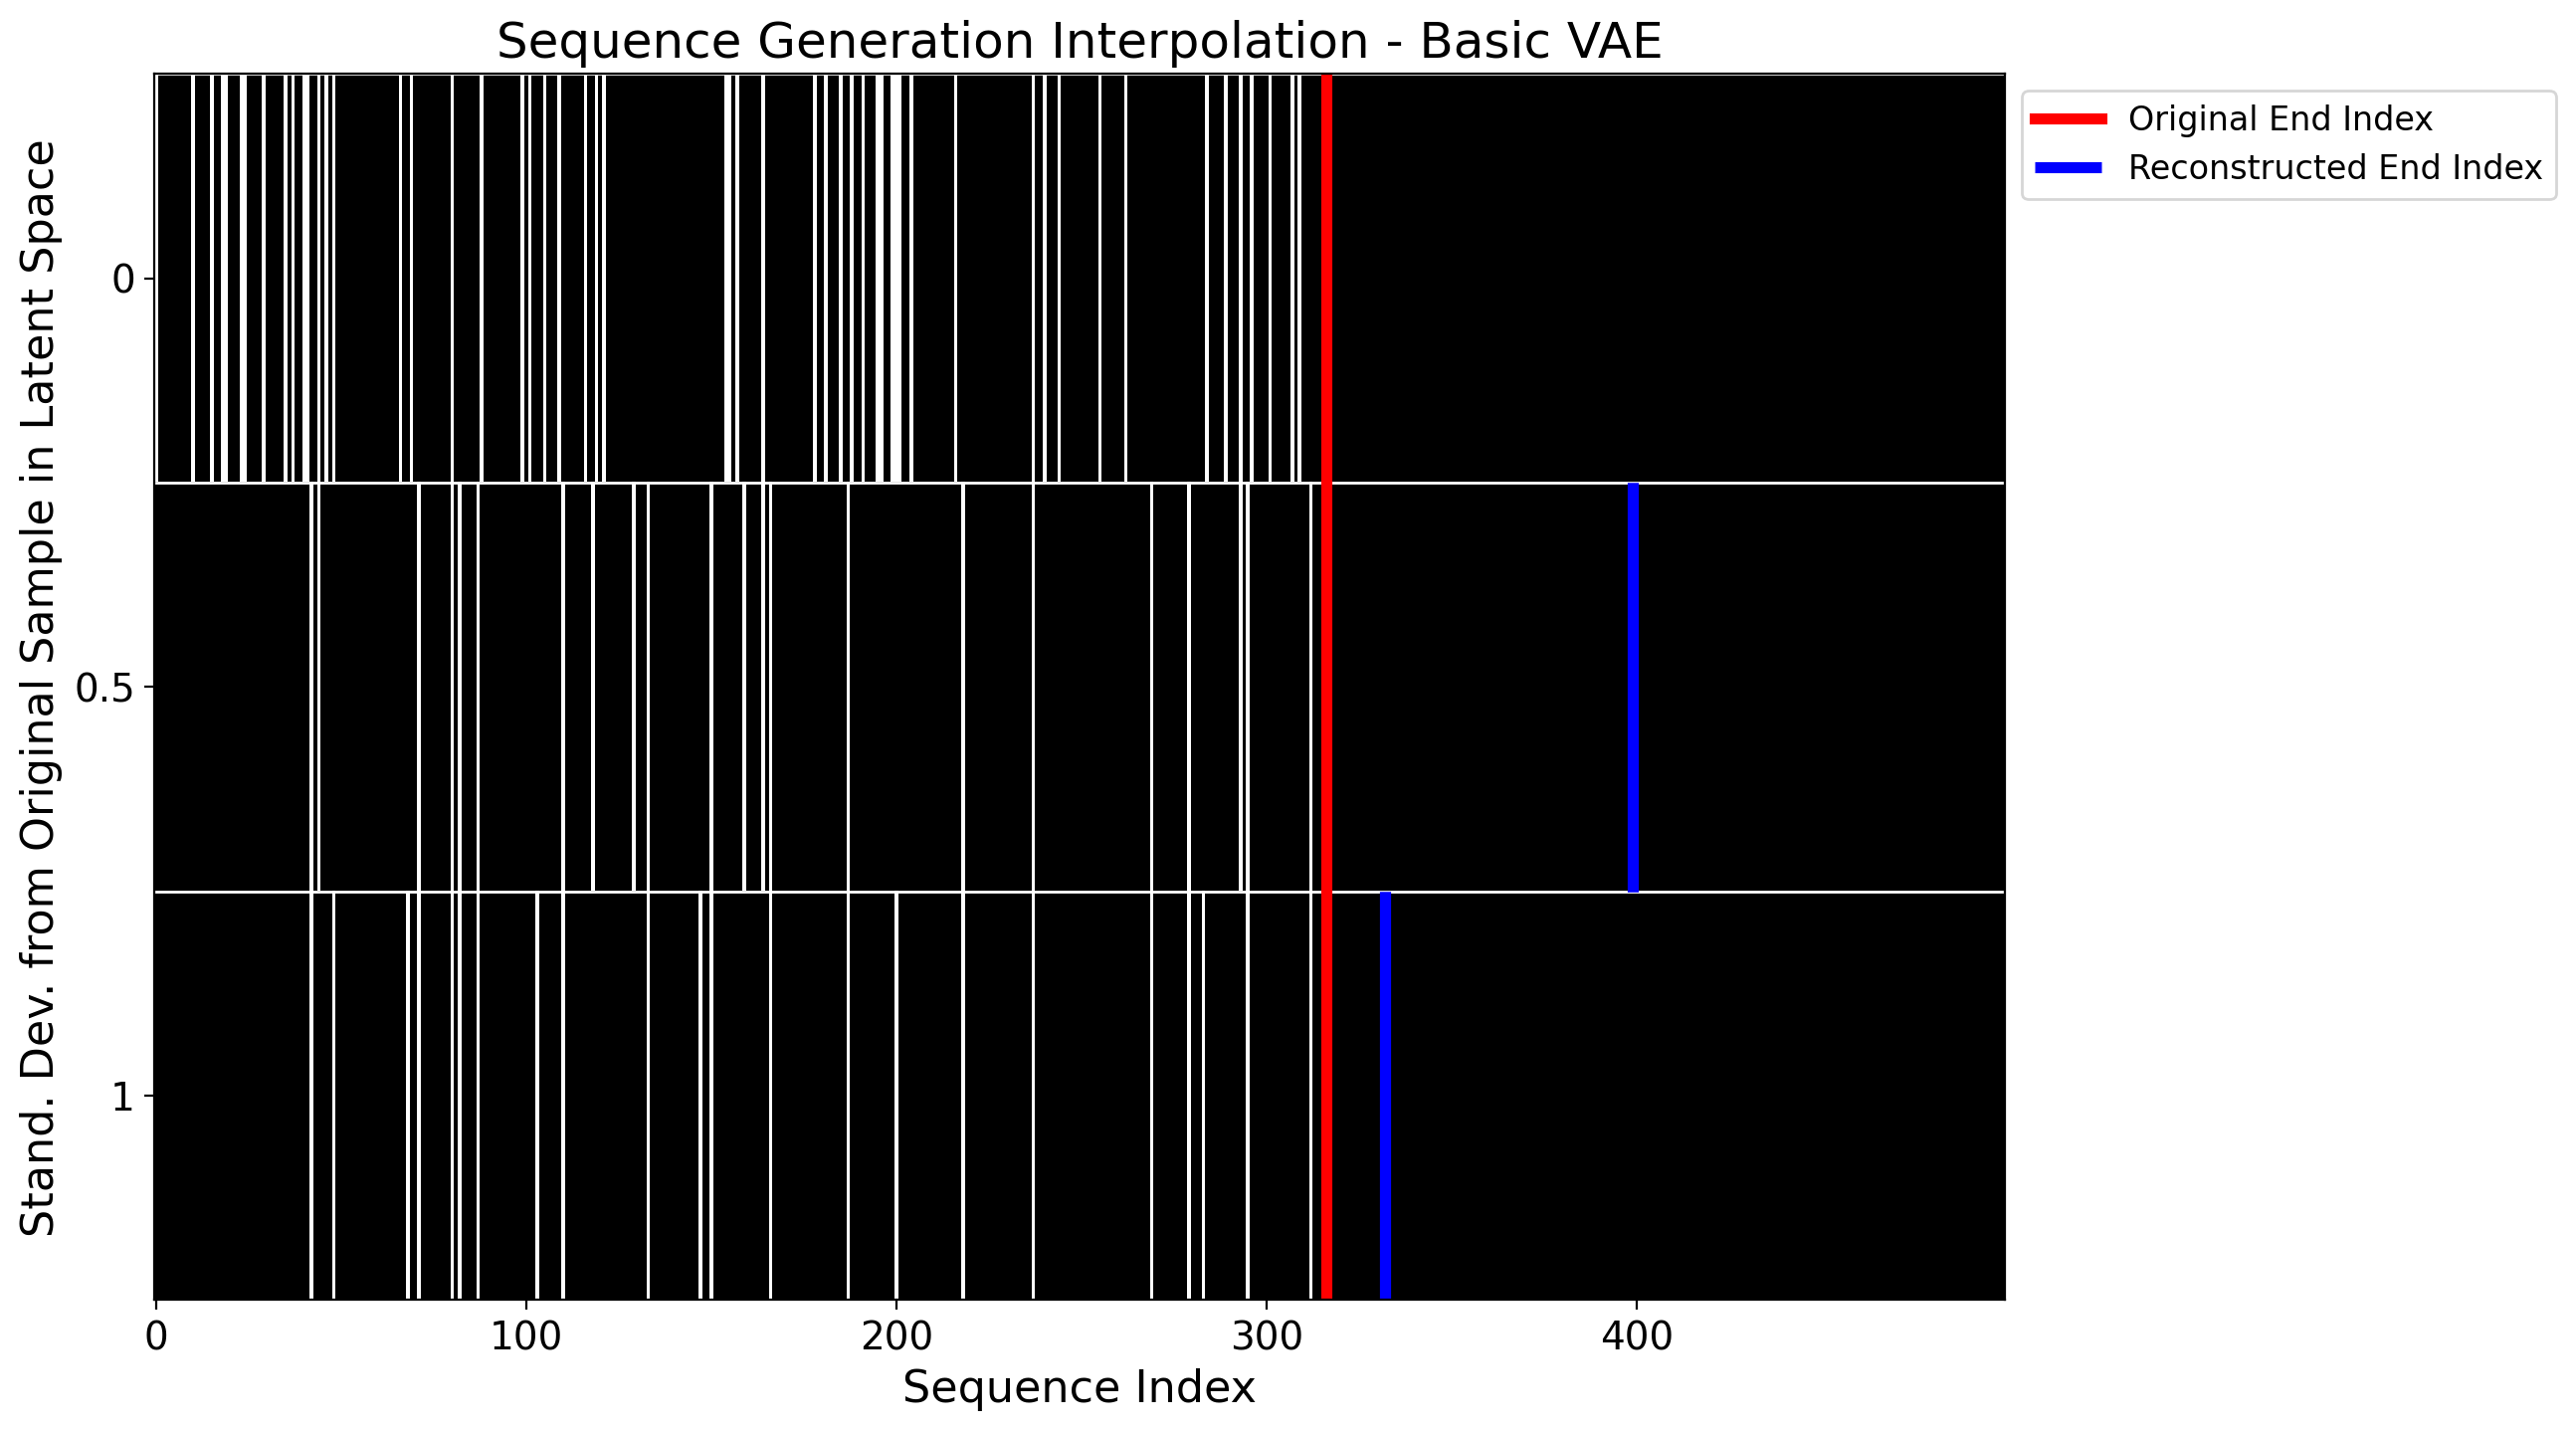

In [287]:
# Create a DataFrame with random values
# Generate random data
data = difference_vectors[1:,:500]  # 6x6 matrix

fig, ax = plt.subplots(figsize=(12, 8), dpi = 200)  # Adjust size here
# cmap = plt.cm.colors.ListedColormap(["red", "black"])
# Display heatmap
cax = ax.imshow(data, cmap='grey', aspect="auto")
# plt.colorbar(cax)

for i in range(data.shape[0]):
    ax.hlines(i - 0.5, -0.5, data.shape[1] - 0.5, color="white", linewidth=1)

yticks = [0, 0.5, 1]

for i in range(len(sequence_vectors)-1):

    if i == 0:
        ax.axvline(x=end_idx+1, color='red', linestyle='-', linewidth=4, label = 'Original End Index')
    else:
        prop_idx = torch.where(sequence_vectors[i] == 20)[0][0].item()
        if i == 1:
            ax.vlines([prop_idx, prop_idx], ymin = -0.5+i, ymax = (i)+0.5, color='b', linestyle='-', linewidth=4, label = 'Reconstructed End Index')
        else:
            ax.vlines([prop_idx, prop_idx], ymin = -0.5+i, ymax = (i)+0.5, color='b', linestyle='-', linewidth=4)

plt.yticks(range(data.shape[0]), yticks)
ax.tick_params(axis='both', labelsize=14) 
plt.ylabel('Stand. Dev. from Original Sample in Latent Space', fontsize = 16)
plt.title("Sequence Generation Interpolation - Basic VAE", fontsize = 18)
plt.xlabel('Sequence Index', fontsize = 16)
ax.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=12)
plt.show()